### 전이학습(Transfer Learning)
#### train : 2000 images [cat(1000) + dog(1000)]  , size는 다름
#### validation : 1000 images [cat(500) + dog(500)] , size는 다름

In [1]:
import tensorflow as tf
import urllib
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop

from tensorflow.keras import layers
from tensorflow.keras import Model

In [13]:
# Google InceptionV3 pretrained model 가중치 다운로드, Windows용
_INCEPTION_URL = "https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
urllib.request.urlretrieve(_INCEPTION_URL, 'tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5')

('tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5',
 <http.client.HTTPMessage at 0x2187763e500>)

In [3]:
# 사전훈련된 가중치 불러오기
from tensorflow.keras.applications.inception_v3 import InceptionV3
local_weights_file = 'tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
pre_trained_model = InceptionV3(input_shape=(150,150,3),
                               include_top=False,
                               weights=None)

pre_trained_model.load_weights(local_weights_file)

#사전 훈련 계층의 가중치의 훈련(학습) 가능 여부 설정 :False(학습안함)
for layer in pre_trained_model.layers:
    layer.trainable = False

pre_trained_model.summary()

#마지막 층 출력 확인하기
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)#(None, 7, 7, 768)
last_output = last_layer.output
last_output

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

<KerasTensor: shape=(None, 7, 7, 768) dtype=float32 (created by layer 'mixed7')>

In [4]:
#모델구성/컴파일
# Flatten layer
x = layers.Flatten()(last_output) #(None,37622)
# Dense layer : Hidden layer
x = layers.Dense(1024,activation='relu')(x)
# Dropout Layer
x = layers.Dropout(0.2)(x)
# Dense layer : output layer
x = layers.Dense(1,activation='sigmoid')(x)

model = Model(pre_trained_model.input,x)
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=0.0001),
              metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

### 이미지증강(Image Augmentation)

In [5]:
import os

train_cat_dir = os.path.join('tmp/cats_and_dogs_filtered/train/cats')
train_dog_dir = os.path.join('tmp/cats_and_dogs_filtered/train/dogs')
valid_cat_dir = os.path.join('tmp/cats_and_dogs_filtered/validation/cats')
valid_dog_dir = os.path.join('tmp/cats_and_dogs_filtered/validation/dogs')
train_cat_names = os.listdir(train_cat_dir)
train_dog_names = os.listdir(train_dog_dir)
valid_cat_names = os.listdir(valid_cat_dir)
valid_dog_names = os.listdir(valid_dog_dir)

train_dir = 'tmp/cats_and_dogs_filtered/train'
validation_dir = 'tmp/cats_and_dogs_filtered/validation'

In [6]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [7]:
#학습
# 사전 훈련 가중치는 업데이트 하지 않고 추가 계층만 가중치를 업데이트하여 학습
history = model.fit(
      train_generator,
      steps_per_epoch=100,  # 2000 images = batch_size * steps
      epochs=20,
      validation_data=validation_generator,
      validation_steps=50,  # 1000 images = batch_size * steps
      verbose=1)

Epoch 1/20
100/100 [==============================] - 15s 102ms/step - loss: 0.3724 - accuracy: 0.8515 - val_loss: 0.0975 - val_accuracy: 0.9630
Epoch 2/20
100/100 [==============================] - 9s 87ms/step - loss: 0.2230 - accuracy: 0.9055 - val_loss: 0.1751 - val_accuracy: 0.9350
Epoch 3/20
100/100 [==============================] - 9s 87ms/step - loss: 0.2296 - accuracy: 0.9200 - val_loss: 0.0965 - val_accuracy: 0.9650
Epoch 4/20
100/100 [==============================] - 9s 87ms/step - loss: 0.1775 - accuracy: 0.9320 - val_loss: 0.1525 - val_accuracy: 0.9500
Epoch 5/20
100/100 [==============================] - 9s 87ms/step - loss: 0.2142 - accuracy: 0.9315 - val_loss: 0.1016 - val_accuracy: 0.9640
Epoch 6/20
100/100 [==============================] - 9s 87ms/step - loss: 0.1767 - accuracy: 0.9385 - val_loss: 0.1316 - val_accuracy: 0.9580
Epoch 7/20
100/100 [==============================] - 9s 87ms/step - loss: 0.1607 - accuracy: 0.9470 - val_loss: 0.1118 - val_accuracy: 0.96

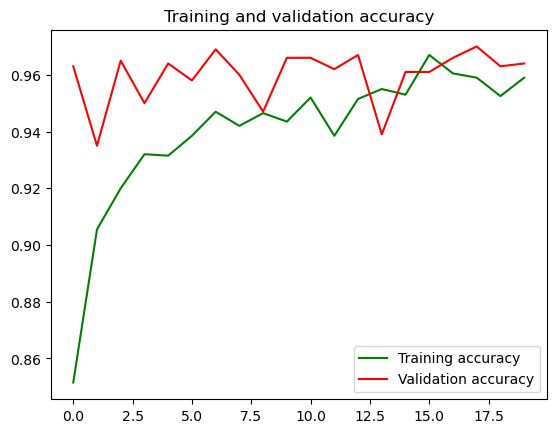

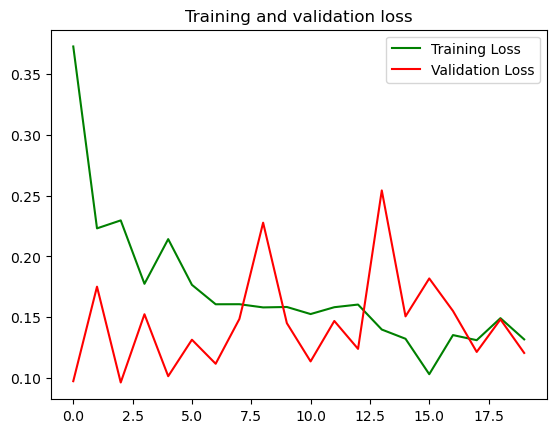

In [8]:
import matplotlib.pyplot as plt
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()